In [1]:
import numpy as np
import pandas as pd 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from keras.models import Sequential
import matplotlib.pyplot as plt
import seaborn as sns

#for RBN
from keras.layers import Layer, Flatten, Dense
from keras import backend as K
from sklearn.metrics import classification_report


from sklearn.model_selection import StratifiedKFold
from keras import regularizers
from tensorflow.keras.utils import to_categorical


In [2]:
#fixed random seed for reproducibility 
np.random.seed(0)

In [3]:

# load dataset (input variables = X, output variables = Y)
df = pd.read_csv("TrainingData.csv")

#count the number of occurances for each osID
OsID_counts = df['OsID'].value_counts()

#filter for osIDs that have 10 or more occurances
OsID_counts_filtered = OsID_counts[OsID_counts >= 10]

#assign a label for each osID 
OsID_labels = {}
class_no = 1
for osID in OsID_counts_filtered.index:
    OsID_labels[osID] = class_no
    class_no +=1

#filter the dataset with osID that contain 10 or more occurances
dataGene = df[df['OsID'].isin(OsID_counts_filtered.index)]

dataGene = dataGene.drop(['Class', 'Trait'],axis=1)

# Add a new column 'class' to the filtered dataset
dataGene['class'] = dataGene['OsID'].map(OsID_labels)

#print("Summary of dataGene:\n",dataGene.describe())


In [4]:
X = dataGene.drop(['class','OsID'], axis=1) # exclude class & OsID column
Y = dataGene['class']

#input feature names in order of descending importance scores in RF feature selection method
feature_names = ['Root10DaysSeedling', 'Leaf45DaysOldPlant', 'Shoot10DaysSeedling', 'Shoot35DaysSeedling', 'Root35DaysSeedling', 
                 'Leaf21DaysSeedling', 'Root14DaysSeedling', 'Shoot3DaysSeedling', 'Root24DaysSeedling', 'Root52DaysSeedling', 
                 'Root17DaysSeedling', 'Root21DaysSeedling', 'Shoot14DaysSeedling', 'Shoot21DaysSeedling', 'Shoot17DaysSeedling',
                  'ET', 'PCC', 'log_2FoldChange', 'PPI', 'CoExpression' ]

X_fs = X.reindex(columns=feature_names)

print("Shape of X:\n",X_fs.shape)
print("Shape of Y:\n",Y.shape)

# Statistical summary of the variables
#print("Summary of X:\n",X_fs.describe())
#print("Summary of Y:\n",Y.describe())

# Check for class imbalance
print(df.groupby(Y).size())

# change both input and target variables datatype to ndarray
X_fs = X_fs.values # 2-D array

# select target variable 

Y = Y.values #1-D array
Y = Y.reshape(-1, 1)

Shape of X:
 (41110, 20)
Shape of Y:
 (41110,)
class
1.0      1800
2.0      1296
3.0      1260
4.0      1218
5.0      1026
6.0      1008
7.0       930
8.0       912
9.0       880
10.0      798
11.0      792
12.0      759
13.0      729
14.0      720
15.0      702
16.0      693
17.0      672
18.0      640
19.0      625
20.0      570
21.0      546
22.0      506
23.0      483
24.0      448
25.0      432
26.0      384
27.0      360
28.0      360
29.0      320
30.0      312
         ... 
344.0      12
345.0      12
346.0      12
347.0      12
348.0      12
349.0      12
350.0      12
351.0      12
352.0      12
353.0      12
354.0      12
355.0      12
356.0      11
357.0      11
358.0      11
359.0      11
360.0      11
361.0      11
362.0      10
363.0      10
364.0      10
365.0      10
366.0      10
367.0      10
368.0      10
369.0      10
370.0      10
371.0      10
372.0      10
373.0      10
Length: 373, dtype: int64


C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Class=0, n=1800 (4.378%)
Class=1, n=1296 (3.153%)
Class=2, n=1260 (3.065%)
Class=3, n=1218 (2.963%)
Class=4, n=1026 (2.496%)
Class=5, n=1008 (2.452%)
Class=6, n=930 (2.262%)
Class=7, n=912 (2.218%)
Class=8, n=880 (2.141%)
Class=9, n=798 (1.941%)
Class=10, n=792 (1.927%)
Class=11, n=759 (1.846%)
Class=12, n=729 (1.773%)
Class=13, n=720 (1.751%)
Class=14, n=702 (1.708%)
Class=15, n=693 (1.686%)
Class=16, n=672 (1.635%)
Class=17, n=640 (1.557%)
Class=18, n=625 (1.520%)
Class=19, n=570 (1.387%)
Class=20, n=546 (1.328%)
Class=21, n=506 (1.231%)
Class=22, n=483 (1.175%)
Class=23, n=448 (1.090%)
Class=24, n=432 (1.051%)
Class=25, n=384 (0.934%)
Class=26, n=360 (0.876%)
Class=27, n=360 (0.876%)
Class=28, n=320 (0.778%)
Class=29, n=312 (0.759%)
Class=30, n=312 (0.759%)
Class=31, n=306 (0.744%)
Class=32, n=304 (0.739%)
Class=33, n=299 (0.727%)
Class=34, n=297 (0.722%)
Class=35, n=296 (0.720%)
Class=36, n=280 (0.681%)
Class=37, n=264 (0.642%)
Class=38, n=260 (0.632%)
Class=39, n=253 (0.615%)
Clas

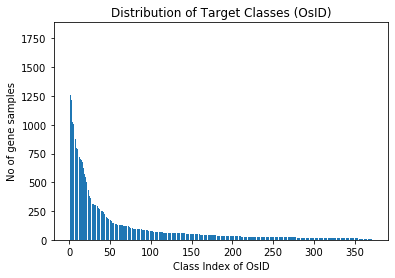

In [5]:
y_labelenc = LabelEncoder().fit_transform(Y)

from collections import Counter
# summarize distribution
counter = Counter(y_labelenc)

# sort counter by keys
counter = dict(sorted(counter.items()))


for k,v in counter.items():
 per = v / len(y_labelenc) * 100
 print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar( counter.keys(), counter.values())

plt.ylabel('No of gene samples')
plt.xlabel('Class Index of OsID')
plt.title('Distribution of Target Classes (OsID)')
plt.show()

In [6]:
# prepare target data
def prepare_targets(y_train, y_test):
	le = LabelEncoder()
	
	#fit the encoders only to the training data and then transform both train and test data
	y_train_enc = le.fit_transform(y_train)
	y_test_enc = le.transform(y_test)

	return y_train_enc, y_test_enc

In [7]:
# define the RBFLayer layer as a custom layer
class RBFLayer(Layer):
    def __init__(self, units, gamma, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = K.cast_to_floatx(gamma)

    def build(self, input_shape):
        self.mu = self.add_weight(name='mu',
                                  shape=(int(input_shape[1]), self.units),
                                  initializer='uniform',
                                  trainable=True)
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        diff = K.expand_dims(inputs) - self.mu
        l2 = K.sum(K.pow(diff, 2), axis=1)
        res = K.exp(-1 * self.gamma * l2)
        return res

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)

In [8]:
# prepare target data
def prepare_targets(y_train, y_test):
	le = LabelEncoder()
	
	#fit the encoders only to the training data and then transform both train and test data
	y_train_enc = le.fit_transform(y_train)
	y_test_enc = le.transform(y_test)

	return y_train_enc, y_test_enc

In [9]:
# define baseline model (RBFN)
def RBFN_model(input_dim):

    model = Sequential()
    model.add(Flatten(input_shape=(input_dim,)))
    #add the RBF layer
    model.add(RBFLayer(10, 0.5))
    
    model.add(Dense(60, input_dim=input_dim, activation='relu',bias_initializer='normal',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(20,bias_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(20,bias_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(373,kernel_initializer='normal',activation='softmax'))

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [10]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_fs, Y, test_size=0.33, random_state=1)

# prepare output data
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)


C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [11]:
# Define the number of folds for k-fold cross-validation
k = 2

# Define the cross-validation method
cv_method = StratifiedKFold(n_splits=k)

# Initialize the list to store the history, train & validation(accuracy & loss) for each model
models = []
model_history = []
model_accuracy = []
model_train_acc = []
model_train_loss = []
model_val_acc = []
model_val_loss = []


for i in range(1,21):

    models_fold = []
    hist = []
    train_accuracy = []
    train_loss = []
    val_accuracy = []
    val_loss = []
    test_accuracy = []

    print("Number of input features:",i)

    # Select the input features from the input data
    X_train_selected = X_train[:, :i]
    X_test_selected = X_test[:, :i]

    # Loop over the folds
    for fold, (train_index, val_index) in enumerate(cv_method.split(X_train_selected, y_train)):

        print("Fold:", fold+1)

        # Split the data into train and validation sets using the current fold index
        X_train_fold  = X_train_selected[train_index]
        y_train_fold  = y_train[train_index]
        X_val_fold = X_train_selected[val_index]
        y_val_fold = y_train[val_index]

        # Prepare the target data
        y_train_fold_enc, y_val_fold_enc = prepare_targets(y_train_fold, y_val_fold)

        # build the model
        model = RBFN_model(i)

        # Fit the model to the training data for the current fold
        history = model.fit(X_train_fold, to_categorical(y_train_fold_enc, num_classes=373), epochs=80, batch_size=5, verbose=1, validation_split = 0.33)
    
        # Evaluate the model on the validation data for the current fold
        val_scores = model.evaluate(X_val_fold, to_categorical(y_val_fold_enc, num_classes=373), verbose=0)
        val_accuracy.append(val_scores[1])
        val_loss.append(val_scores[0])

        # Evaluate the model on the test data for the current fold
        test_scores = model.evaluate(X_test_selected, to_categorical(y_test_enc, num_classes=373), verbose=0)
        test_accuracy.append(test_scores[1])

        # add the model to the list of models
        models_fold.append(model)
        hist.append(history)

        # store the training accuracy and loss for each fold
        train_accuracy.append(history.history['accuracy'])
        train_loss.append(history.history['loss'])
        
    # Calculate the average test and validation accuracy and loss across all folds
    avg_test_acc = sum(test_accuracy) / len(test_accuracy)
    avg_val_acc = sum(val_accuracy) / len(val_accuracy)
    avg_val_loss = sum(val_loss) / len(val_loss)

    # Print the average validation and test accuracy and loss
    print("Average Validation Accuracy:", avg_val_acc)
    print("Average Validation Loss:",avg_val_loss)
    print("Average Test Accuracy:", avg_test_acc)

    best_fold_index = test_accuracy.index(max(test_accuracy))
    model_accuracy.append(test_accuracy[best_fold_index])
    models.append(models_fold[best_fold_index])
    model_history.append(hist[best_fold_index])
    model_train_acc.append(train_accuracy[best_fold_index])
    model_train_loss.append(train_loss[best_fold_index])
    model_val_acc.append(val_accuracy[best_fold_index])
    model_val_loss.append(val_loss[best_fold_index])


    print("Final Test Accuracy for each fold:", test_accuracy[best_fold_index])

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Number of input features: 1
Fold: 1
Epoch 1/80
1846/1846 [==============================] - 11s 4ms/step - loss: 5.0081 - accuracy: 0.0411 - val_loss: 4.9204 - val_accuracy: 0.0315
Epoch 2/80
1846/1846 [==============================] - 5s 3ms/step - loss: 4.4687 - accuracy: 0.0936 - val_loss: 4.3001 - val_accuracy: 0.1210
Epoch 3/80
1846/1846 [==============================] - 6s 3ms/step - loss: 3.9762 - accuracy: 0.1357 - val_loss: 3.8825 - val_accuracy: 0.2119
Epoch 4/80
1846/1846 [==============================] - 6s 3ms/step - loss: 3.6141 - accuracy: 0.1791 - val_loss: 3.6617 - val_accuracy: 0.2075
Epoch 5/80
1846/1846 [==============================] - 6s 3ms/step - loss: 3.3793 - accuracy: 0.2160 - val_loss: 3.4745 - val_accuracy: 0.2154
Epoch 6/80
1846/1846 [==============================] - 6s 3ms/step - loss: 3.1790 - accuracy: 0.2456 - val_loss: 3.2735 - val_accuracy: 0.2143
Epoch 7/80
1846/1846 [==============================] - 6s 3ms/step - loss: 3.0048 - accuracy: 0.27

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/80
1846/1846 [==============================] - 13s 5ms/step - loss: 4.9984 - accuracy: 0.0442 - val_loss: 4.8382 - val_accuracy: 0.0750
Epoch 2/80
1846/1846 [==============================] - 7s 4ms/step - loss: 4.4309 - accuracy: 0.0986 - val_loss: 4.2494 - val_accuracy: 0.1694
Epoch 3/80
1846/1846 [==============================] - 8s 4ms/step - loss: 3.9036 - accuracy: 0.1599 - val_loss: 3.7603 - val_accuracy: 0.2686
Epoch 4/80
1846/1846 [==============================] - 7s 4ms/step - loss: 3.4077 - accuracy: 0.2223 - val_loss: 3.3637 - val_accuracy: 0.2295
Epoch 5/80
1846/1846 [==============================] - 7s 4ms/step - loss: 3.0469 - accuracy: 0.2834 - val_loss: 3.1094 - val_accuracy: 0.3019
Epoch 6/80
1846/1846 [==============================] - 9s 5ms/step - loss: 2.7761 - accuracy: 0.3415 - val_loss: 2.8607 - val_accuracy: 0.3861
Epoch 7/80
1846/1846 [==============================] - 9s 5ms/step - loss: 2.5331 - accuracy: 0.3894 - val_loss: 2.6404 - val_accuracy

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/80
1846/1846 [==============================] - 15s 5ms/step - loss: 4.9705 - accuracy: 0.0499 - val_loss: 4.6050 - val_accuracy: 0.0860
Epoch 2/80
1846/1846 [==============================] - 8s 4ms/step - loss: 4.2294 - accuracy: 0.1417 - val_loss: 4.1238 - val_accuracy: 0.1670
Epoch 3/80
1846/1846 [==============================] - 8s 5ms/step - loss: 3.7036 - accuracy: 0.2379 - val_loss: 3.4789 - val_accuracy: 0.2979
Epoch 4/80
1846/1846 [==============================] - 8s 4ms/step - loss: 2.9221 - accuracy: 0.3657 - val_loss: 2.8006 - val_accuracy: 0.3952
Epoch 5/80
1846/1846 [==============================] - 6s 3ms/step - loss: 2.3308 - accuracy: 0.4376 - val_loss: 2.3800 - val_accuracy: 0.4422
Epoch 6/80
1846/1846 [==============================] - 6s 3ms/step - loss: 1.9351 - accuracy: 0.5155 - val_loss: 2.0689 - val_accuracy: 0.5668
Epoch 7/80
1846/1846 [==============================] - 8s 4ms/step - loss: 1.6741 - accuracy: 0.5719 - val_loss: 1.9166 - val_accuracy

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/80
1846/1846 [==============================] - 13s 5ms/step - loss: 4.8120 - accuracy: 0.0739 - val_loss: 4.1961 - val_accuracy: 0.1602
Epoch 2/80
1846/1846 [==============================] - 8s 4ms/step - loss: 3.6522 - accuracy: 0.2731 - val_loss: 3.3972 - val_accuracy: 0.3259
Epoch 3/80
1846/1846 [==============================] - 8s 4ms/step - loss: 2.9226 - accuracy: 0.4131 - val_loss: 2.7910 - val_accuracy: 0.4664
Epoch 4/80
1846/1846 [==============================] - 8s 4ms/step - loss: 2.3561 - accuracy: 0.5205 - val_loss: 2.3621 - val_accuracy: 0.5657
Epoch 5/80
1846/1846 [==============================] - 8s 4ms/step - loss: 1.9298 - accuracy: 0.6038 - val_loss: 2.0937 - val_accuracy: 0.5795
Epoch 6/80
1846/1846 [==============================] - 8s 4ms/step - loss: 1.6243 - accuracy: 0.6469 - val_loss: 1.8578 - val_accuracy: 0.6334
Epoch 7/80
1846/1846 [==============================] - 8s 4ms/step - loss: 1.4054 - accuracy: 0.6803 - val_loss: 1.7175 - val_accuracy

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/80
1846/1846 [==============================] - 15s 5ms/step - loss: 4.6307 - accuracy: 0.0927 - val_loss: 4.1389 - val_accuracy: 0.0761
Epoch 2/80
1846/1846 [==============================] - 8s 4ms/step - loss: 3.7355 - accuracy: 0.1836 - val_loss: 3.5577 - val_accuracy: 0.3001
Epoch 3/80
1846/1846 [==============================] - 9s 5ms/step - loss: 3.0479 - accuracy: 0.3470 - val_loss: 2.9877 - val_accuracy: 0.4095
Epoch 4/80
1846/1846 [==============================] - 8s 4ms/step - loss: 2.4930 - accuracy: 0.4472 - val_loss: 2.5373 - val_accuracy: 0.4781
Epoch 5/80
1846/1846 [==============================] - 8s 4ms/step - loss: 2.0539 - accuracy: 0.5228 - val_loss: 2.2429 - val_accuracy: 0.5252
Epoch 6/80
1846/1846 [==============================] - 9s 5ms/step - loss: 1.7341 - accuracy: 0.5848 - val_loss: 1.9715 - val_accuracy: 0.5993
Epoch 7/80
1846/1846 [==============================] - 8s 5ms/step - loss: 1.5001 - accuracy: 0.6367 - val_loss: 1.8281 - val_accuracy

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/80
1846/1846 [==============================] - 15s 5ms/step - loss: 4.5191 - accuracy: 0.0967 - val_loss: 4.0055 - val_accuracy: 0.1663
Epoch 2/80
1846/1846 [==============================] - 9s 5ms/step - loss: 3.5799 - accuracy: 0.2057 - val_loss: 3.3893 - val_accuracy: 0.2823
Epoch 3/80
1846/1846 [==============================] - 9s 5ms/step - loss: 2.8798 - accuracy: 0.3868 - val_loss: 2.7564 - val_accuracy: 0.4348
Epoch 4/80
1846/1846 [==============================] - 9s 5ms/step - loss: 2.2621 - accuracy: 0.4969 - val_loss: 2.2734 - val_accuracy: 0.5142
Epoch 5/80
1846/1846 [==============================] - 9s 5ms/step - loss: 1.8311 - accuracy: 0.5645 - val_loss: 1.9868 - val_accuracy: 0.5868
Epoch 6/80
1846/1846 [==============================] - 8s 5ms/step - loss: 1.5586 - accuracy: 0.6059 - val_loss: 1.7746 - val_accuracy: 0.6147
Epoch 7/80
1846/1846 [==============================] - 9s 5ms/step - loss: 1.3616 - accuracy: 0.6446 - val_loss: 1.6097 - val_accuracy

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/80
1846/1846 [==============================] - 14s 5ms/step - loss: 4.5496 - accuracy: 0.0788 - val_loss: 4.0450 - val_accuracy: 0.1190
Epoch 2/80
1846/1846 [==============================] - 8s 4ms/step - loss: 3.4899 - accuracy: 0.2753 - val_loss: 3.2075 - val_accuracy: 0.4150
Epoch 3/80
1846/1846 [==============================] - 8s 4ms/step - loss: 2.6306 - accuracy: 0.4843 - val_loss: 2.5281 - val_accuracy: 0.5303
Epoch 4/80
1846/1846 [==============================] - 8s 4ms/step - loss: 2.0154 - accuracy: 0.5774 - val_loss: 2.0809 - val_accuracy: 0.6191
Epoch 5/80
1846/1846 [==============================] - 8s 4ms/step - loss: 1.6105 - accuracy: 0.6498 - val_loss: 1.7688 - val_accuracy: 0.6574
Epoch 6/80
1846/1846 [==============================] - 8s 4ms/step - loss: 1.3477 - accuracy: 0.6847 - val_loss: 1.5841 - val_accuracy: 0.6777
Epoch 7/80
1846/1846 [==============================] - 8s 4ms/step - loss: 1.1660 - accuracy: 0.7152 - val_loss: 1.4541 - val_accuracy

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/80
1846/1846 [==============================] - 15s 5ms/step - loss: 4.5735 - accuracy: 0.0791 - val_loss: 4.0909 - val_accuracy: 0.1536
Epoch 2/80
1846/1846 [==============================] - 9s 5ms/step - loss: 3.5412 - accuracy: 0.2423 - val_loss: 3.2810 - val_accuracy: 0.3303
Epoch 3/80
1846/1846 [==============================] - 8s 4ms/step - loss: 2.7157 - accuracy: 0.4261 - val_loss: 2.6079 - val_accuracy: 0.4867
Epoch 4/80
1846/1846 [==============================] - 9s 5ms/step - loss: 2.0812 - accuracy: 0.5545 - val_loss: 2.1548 - val_accuracy: 0.5776
Epoch 5/80
1846/1846 [==============================] - 8s 4ms/step - loss: 1.6726 - accuracy: 0.6249 - val_loss: 1.8646 - val_accuracy: 0.6526
Epoch 6/80
1846/1846 [==============================] - 8s 4ms/step - loss: 1.4083 - accuracy: 0.6735 - val_loss: 1.7377 - val_accuracy: 0.6475
Epoch 7/80
1846/1846 [==============================] - 8s 4ms/step - loss: 1.2312 - accuracy: 0.6994 - val_loss: 1.5937 - val_accuracy

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/80
1846/1846 [==============================] - 15s 5ms/step - loss: 4.6057 - accuracy: 0.0768 - val_loss: 4.0177 - val_accuracy: 0.1584
Epoch 2/80
1846/1846 [==============================] - 9s 5ms/step - loss: 3.4176 - accuracy: 0.3034 - val_loss: 3.1907 - val_accuracy: 0.3857
Epoch 3/80
1846/1846 [==============================] - 8s 4ms/step - loss: 2.5279 - accuracy: 0.4879 - val_loss: 2.4479 - val_accuracy: 0.5078
Epoch 4/80
1846/1846 [==============================] - 9s 5ms/step - loss: 1.8632 - accuracy: 0.5938 - val_loss: 1.9850 - val_accuracy: 0.6257
Epoch 5/80
1846/1846 [==============================] - 9s 5ms/step - loss: 1.4517 - accuracy: 0.6742 - val_loss: 1.6733 - val_accuracy: 0.6917
Epoch 6/80
1846/1846 [==============================] - 9s 5ms/step - loss: 1.2003 - accuracy: 0.7122 - val_loss: 1.4832 - val_accuracy: 0.7289
Epoch 7/80
1846/1846 [==============================] - 9s 5ms/step - loss: 1.0584 - accuracy: 0.7425 - val_loss: 1.3801 - val_accuracy

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/80
1846/1846 [==============================] - 10s 4ms/step - loss: 4.4913 - accuracy: 0.0981 - val_loss: 3.9259 - val_accuracy: 0.1626
Epoch 2/80
1846/1846 [==============================] - 6s 3ms/step - loss: 3.4405 - accuracy: 0.2585 - val_loss: 3.1924 - val_accuracy: 0.3910
Epoch 3/80
1846/1846 [==============================] - 6s 3ms/step - loss: 2.6413 - accuracy: 0.4452 - val_loss: 2.5499 - val_accuracy: 0.5085
Epoch 4/80
1846/1846 [==============================] - 6s 3ms/step - loss: 2.0410 - accuracy: 0.5692 - val_loss: 2.1026 - val_accuracy: 0.5661
Epoch 5/80
1846/1846 [==============================] - 6s 3ms/step - loss: 1.6276 - accuracy: 0.6395 - val_loss: 1.7822 - val_accuracy: 0.6561
Epoch 6/80
1846/1846 [==============================] - 6s 3ms/step - loss: 1.3523 - accuracy: 0.6918 - val_loss: 1.5934 - val_accuracy: 0.6924
Epoch 7/80
1846/1846 [==============================] - 6s 3ms/step - loss: 1.1797 - accuracy: 0.7180 - val_loss: 1.4610 - val_accuracy

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/80
1846/1846 [==============================] - 11s 4ms/step - loss: 4.7116 - accuracy: 0.0658 - val_loss: 4.2759 - val_accuracy: 0.0917
Epoch 2/80
1846/1846 [==============================] - 6s 3ms/step - loss: 3.8456 - accuracy: 0.1504 - val_loss: 3.6578 - val_accuracy: 0.1949
Epoch 3/80
1846/1846 [==============================] - 6s 3ms/step - loss: 3.2041 - accuracy: 0.2842 - val_loss: 3.0616 - val_accuracy: 0.3652
Epoch 4/80
1846/1846 [==============================] - 6s 3ms/step - loss: 2.5403 - accuracy: 0.4609 - val_loss: 2.3693 - val_accuracy: 0.5190
Epoch 5/80
1846/1846 [==============================] - 6s 3ms/step - loss: 1.8543 - accuracy: 0.5754 - val_loss: 1.9140 - val_accuracy: 0.6073
Epoch 6/80
1846/1846 [==============================] - 6s 4ms/step - loss: 1.4296 - accuracy: 0.6629 - val_loss: 1.6338 - val_accuracy: 0.6763
Epoch 7/80
1846/1846 [==============================] - 6s 4ms/step - loss: 1.1740 - accuracy: 0.7091 - val_loss: 1.4505 - val_accuracy

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/80
1846/1846 [==============================] - 9s 4ms/step - loss: 4.4919 - accuracy: 0.0840 - val_loss: 4.0645 - val_accuracy: 0.1461
Epoch 2/80
1846/1846 [==============================] - 6s 3ms/step - loss: 3.5989 - accuracy: 0.1827 - val_loss: 3.4458 - val_accuracy: 0.1971
Epoch 3/80
1846/1846 [==============================] - 6s 3ms/step - loss: 3.0151 - accuracy: 0.2860 - val_loss: 2.8886 - val_accuracy: 0.3778
Epoch 4/80
1846/1846 [==============================] - 6s 3ms/step - loss: 2.2620 - accuracy: 0.5008 - val_loss: 2.2046 - val_accuracy: 0.5586
Epoch 5/80
1846/1846 [==============================] - 6s 3ms/step - loss: 1.7318 - accuracy: 0.6016 - val_loss: 1.8441 - val_accuracy: 0.6304
Epoch 6/80
1846/1846 [==============================] - 6s 3ms/step - loss: 1.4403 - accuracy: 0.6594 - val_loss: 1.6307 - val_accuracy: 0.6748
Epoch 7/80
1846/1846 [==============================] - 6s 3ms/step - loss: 1.2560 - accuracy: 0.6951 - val_loss: 1.4786 - val_accuracy:

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/80
1846/1846 [==============================] - 9s 3ms/step - loss: 4.5726 - accuracy: 0.0776 - val_loss: 4.0751 - val_accuracy: 0.1197
Epoch 2/80
1846/1846 [==============================] - 5s 3ms/step - loss: 3.6284 - accuracy: 0.1813 - val_loss: 3.5130 - val_accuracy: 0.1998
Epoch 3/80
1846/1846 [==============================] - 6s 3ms/step - loss: 2.9830 - accuracy: 0.3620 - val_loss: 2.7812 - val_accuracy: 0.4667
Epoch 4/80
1846/1846 [==============================] - 6s 3ms/step - loss: 2.2448 - accuracy: 0.5062 - val_loss: 2.2348 - val_accuracy: 0.5487
Epoch 5/80
1846/1846 [==============================] - 5s 3ms/step - loss: 1.7388 - accuracy: 0.6113 - val_loss: 1.8729 - val_accuracy: 0.6352
Epoch 6/80
1846/1846 [==============================] - 5s 3ms/step - loss: 1.4079 - accuracy: 0.6823 - val_loss: 1.6616 - val_accuracy: 0.6891
Epoch 7/80
1846/1846 [==============================] - 5s 3ms/step - loss: 1.1842 - accuracy: 0.7241 - val_loss: 1.4520 - val_accuracy:

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/80
1846/1846 [==============================] - 10s 4ms/step - loss: 4.6198 - accuracy: 0.0659 - val_loss: 4.2066 - val_accuracy: 0.0579
Epoch 2/80
1846/1846 [==============================] - 5s 3ms/step - loss: 3.8105 - accuracy: 0.1418 - val_loss: 3.6458 - val_accuracy: 0.1692
Epoch 3/80
1846/1846 [==============================] - 6s 3ms/step - loss: 3.2761 - accuracy: 0.2404 - val_loss: 3.2507 - val_accuracy: 0.2596
Epoch 4/80
1846/1846 [==============================] - 6s 3ms/step - loss: 2.8569 - accuracy: 0.3115 - val_loss: 2.8913 - val_accuracy: 0.3096
Epoch 5/80
1846/1846 [==============================] - 5s 3ms/step - loss: 2.4007 - accuracy: 0.4370 - val_loss: 2.4244 - val_accuracy: 0.4766
Epoch 6/80
1846/1846 [==============================] - 5s 3ms/step - loss: 1.9354 - accuracy: 0.5573 - val_loss: 2.0760 - val_accuracy: 0.5839
Epoch 7/80
1846/1846 [==============================] - 6s 3ms/step - loss: 1.6348 - accuracy: 0.6152 - val_loss: 1.8836 - val_accuracy

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/80
1846/1846 [==============================] - 9s 3ms/step - loss: 4.5383 - accuracy: 0.0772 - val_loss: 4.0568 - val_accuracy: 0.1204
Epoch 2/80
1846/1846 [==============================] - 7s 4ms/step - loss: 3.5267 - accuracy: 0.1991 - val_loss: 3.3157 - val_accuracy: 0.3124
Epoch 3/80
1846/1846 [==============================] - 6s 3ms/step - loss: 2.7229 - accuracy: 0.4166 - val_loss: 2.5667 - val_accuracy: 0.4631
Epoch 4/80
1846/1846 [==============================] - 6s 3ms/step - loss: 2.0355 - accuracy: 0.5577 - val_loss: 2.0366 - val_accuracy: 0.6180
Epoch 5/80
1846/1846 [==============================] - 6s 3ms/step - loss: 1.6127 - accuracy: 0.6420 - val_loss: 1.7414 - val_accuracy: 0.6640
Epoch 6/80
1846/1846 [==============================] - 6s 3ms/step - loss: 1.3340 - accuracy: 0.6885 - val_loss: 1.5216 - val_accuracy: 0.6979
Epoch 7/80
1846/1846 [==============================] - 6s 3ms/step - loss: 1.1427 - accuracy: 0.7248 - val_loss: 1.3435 - val_accuracy:

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/80
1846/1846 [==============================] - 14s 4ms/step - loss: 4.7171 - accuracy: 0.0727 - val_loss: 4.1798 - val_accuracy: 0.0911
Epoch 2/80
1846/1846 [==============================] - 8s 5ms/step - loss: 3.7851 - accuracy: 0.1631 - val_loss: 3.6159 - val_accuracy: 0.1732
Epoch 3/80
1846/1846 [==============================] - 7s 4ms/step - loss: 3.2792 - accuracy: 0.2254 - val_loss: 3.1823 - val_accuracy: 0.2772
Epoch 4/80
1846/1846 [==============================] - 8s 4ms/step - loss: 2.8216 - accuracy: 0.3500 - val_loss: 2.6854 - val_accuracy: 0.4196
Epoch 5/80
1846/1846 [==============================] - 7s 4ms/step - loss: 2.3174 - accuracy: 0.4882 - val_loss: 2.3739 - val_accuracy: 0.4935
Epoch 6/80
1846/1846 [==============================] - 7s 4ms/step - loss: 1.9502 - accuracy: 0.5648 - val_loss: 2.0321 - val_accuracy: 0.5391
Epoch 7/80
1846/1846 [==============================] - 7s 4ms/step - loss: 1.6871 - accuracy: 0.6072 - val_loss: 1.7800 - val_accuracy

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/80
1846/1846 [==============================] - 14s 5ms/step - loss: 4.7466 - accuracy: 0.0673 - val_loss: 4.2612 - val_accuracy: 0.0902
Epoch 2/80
1846/1846 [==============================] - 8s 4ms/step - loss: 3.8884 - accuracy: 0.1480 - val_loss: 3.7728 - val_accuracy: 0.1780
Epoch 3/80
1846/1846 [==============================] - 7s 4ms/step - loss: 3.4528 - accuracy: 0.1962 - val_loss: 3.3892 - val_accuracy: 0.2429
Epoch 4/80
1846/1846 [==============================] - 8s 4ms/step - loss: 2.9959 - accuracy: 0.2930 - val_loss: 2.9022 - val_accuracy: 0.3351
Epoch 5/80
1846/1846 [==============================] - 7s 4ms/step - loss: 2.4731 - accuracy: 0.4143 - val_loss: 2.4475 - val_accuracy: 0.4524
Epoch 6/80
1846/1846 [==============================] - 7s 4ms/step - loss: 2.1142 - accuracy: 0.4837 - val_loss: 2.1847 - val_accuracy: 0.4898
Epoch 7/80
1846/1846 [==============================] - 7s 4ms/step - loss: 1.8838 - accuracy: 0.5268 - val_loss: 2.0230 - val_accuracy

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/80
1846/1846 [==============================] - 15s 5ms/step - loss: 4.8159 - accuracy: 0.0592 - val_loss: 4.3465 - val_accuracy: 0.1122
Epoch 2/80
1846/1846 [==============================] - 7s 4ms/step - loss: 3.9507 - accuracy: 0.1513 - val_loss: 3.7500 - val_accuracy: 0.1710
Epoch 3/80
1846/1846 [==============================] - 7s 4ms/step - loss: 3.4057 - accuracy: 0.2149 - val_loss: 3.2710 - val_accuracy: 0.2939
Epoch 4/80
1846/1846 [==============================] - 7s 4ms/step - loss: 2.8602 - accuracy: 0.3357 - val_loss: 2.7734 - val_accuracy: 0.3864
Epoch 5/80
1846/1846 [==============================] - 8s 4ms/step - loss: 2.3951 - accuracy: 0.4369 - val_loss: 2.4654 - val_accuracy: 0.4370
Epoch 6/80
1846/1846 [==============================] - 7s 4ms/step - loss: 2.0978 - accuracy: 0.4949 - val_loss: 2.2085 - val_accuracy: 0.5076
Epoch 7/80
1846/1846 [==============================] - 7s 4ms/step - loss: 1.9040 - accuracy: 0.5303 - val_loss: 2.0533 - val_accuracy

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/80
1846/1846 [==============================] - 15s 4ms/step - loss: 4.7273 - accuracy: 0.0750 - val_loss: 4.2202 - val_accuracy: 0.1113
Epoch 2/80
1846/1846 [==============================] - 8s 4ms/step - loss: 3.7990 - accuracy: 0.1698 - val_loss: 3.6226 - val_accuracy: 0.1789
Epoch 3/80
1846/1846 [==============================] - 7s 4ms/step - loss: 3.2113 - accuracy: 0.2675 - val_loss: 3.0389 - val_accuracy: 0.3102
Epoch 4/80
1846/1846 [==============================] - 7s 4ms/step - loss: 2.6501 - accuracy: 0.3761 - val_loss: 2.5973 - val_accuracy: 0.4174
Epoch 5/80
1846/1846 [==============================] - 7s 4ms/step - loss: 2.2766 - accuracy: 0.4523 - val_loss: 2.3323 - val_accuracy: 0.4680
Epoch 6/80
1846/1846 [==============================] - 7s 4ms/step - loss: 2.0270 - accuracy: 0.5046 - val_loss: 2.1282 - val_accuracy: 0.5256
Epoch 7/80
1846/1846 [==============================] - 7s 4ms/step - loss: 1.8427 - accuracy: 0.5471 - val_loss: 2.0564 - val_accuracy

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/80
1846/1846 [==============================] - 16s 5ms/step - loss: 4.9700 - accuracy: 0.0421 - val_loss: 4.8032 - val_accuracy: 0.0493
Epoch 2/80
1846/1846 [==============================] - 7s 4ms/step - loss: 4.6577 - accuracy: 0.0553 - val_loss: 4.6012 - val_accuracy: 0.0706
Epoch 3/80
1846/1846 [==============================] - 7s 4ms/step - loss: 4.2554 - accuracy: 0.0983 - val_loss: 4.0568 - val_accuracy: 0.1045
Epoch 4/80
1846/1846 [==============================] - 8s 4ms/step - loss: 3.7087 - accuracy: 0.1683 - val_loss: 3.6463 - val_accuracy: 0.1727
Epoch 5/80
1846/1846 [==============================] - 7s 4ms/step - loss: 3.3687 - accuracy: 0.2135 - val_loss: 3.4153 - val_accuracy: 0.2136
Epoch 6/80
1846/1846 [==============================] - 7s 4ms/step - loss: 3.1330 - accuracy: 0.2508 - val_loss: 3.2182 - val_accuracy: 0.2515
Epoch 7/80
1846/1846 [==============================] - 7s 4ms/step - loss: 2.9200 - accuracy: 0.2976 - val_loss: 3.0163 - val_accuracy

In [12]:
#to show the no of input features and its corresponding model accuracy
model_list = []

#Iterate through each model's accuracy 
for i in range (len(model_accuracy)):
    #get the number of input features for the current model
    no_features = i + 1

    #round the model accuries to 3 d.p.
    rounded_model_acc = round(model_accuracy[i], 3)
    
    model_list.append([no_features, rounded_model_acc])

models_df = pd.DataFrame(model_list, columns=["No of input features", "Model accuracy"])

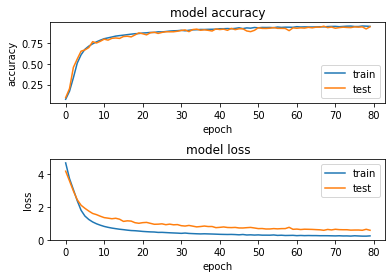

Final Test Accuracy: 0.9576914310455322


In [13]:
# Select the final model based on the max test accuracy across all models

best_model_index = model_accuracy.index(max(model_accuracy))

best_model = models[best_model_index]
best_model_history = model_history[best_model_index]
best_model_train_acc = model_train_acc[best_model_index]
best_model_train_loss = model_train_loss[best_model_index]
best_model_val_acc = model_val_acc[best_model_index]
best_model_val_loss = model_val_loss[best_model_index]

# summarize history for accuracy  
plt.subplot(211)  
plt.plot(best_model_history.history['accuracy'])  
plt.plot(best_model_history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='lower right')  

# summarize history for loss
plt.subplot(212)  
plt.plot(best_model_history.history['loss'])  
plt.plot(best_model_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper right')  
plt.subplots_adjust(hspace=0.7)

plt.show() 

print("Final Test Accuracy:", model_accuracy[best_model_index])

In [14]:
#Select only the optimal number of input features for X_test
X_test = X_test[:,:(best_model_index+1)]

# Evaluate the best model on the test data
y_pred = best_model.predict(X_test)

# np.argmax() is used to convert the one-hot encoded predictions and test labels to class labels.
y_pred_label = np.argmax(y_pred, axis = 1)

# Print the classification report
print("Classification report:\n", classification_report(y_test_enc, y_pred_label))

424/424 [==============================] - 1s 2ms/step
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       591
           1       1.00      1.00      1.00       430
           2       1.00      1.00      1.00       419
           3       1.00      1.00      1.00       384
           4       0.99      1.00      0.99       339
           5       1.00      1.00      1.00       342
           6       1.00      1.00      1.00       310
           7       1.00      1.00      1.00       325
           8       1.00      1.00      1.00       294
           9       1.00      1.00      1.00       269
          10       1.00      1.00      1.00       296
          11       1.00      1.00      1.00       258
          12       1.00      1.00      1.00       247
          13       0.94      1.00      0.97       237
          14       1.00      1.00      1.00       239
          15       1.00      1.00      1.00       235
  

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

In [15]:
# extract class labels from test data
class_test = y_test_enc

# Invert OsID_labels dictionary
inv_OsID_labels = {v: k for k, v in OsID_labels.items()}

# map OsID values to the class labels
OsID_test = [inv_OsID_labels.get(value, 'Unknown') for value in class_test]

# create dataframe with OsID, true class, predicted class, and true/false columns
results = pd.DataFrame({
    'OsID': OsID_test,
    'True Class': y_test_enc,
    'Predicted Class': y_pred_label,
    'True/False': class_test == y_pred_label
})

# display dataframe
print(results.head())

# save results_df to a CSV file
results.to_csv('MLP_gene classification.csv', index=False)

           OsID  True Class  Predicted Class  True/False
0  Os06g0693700         328              270       False
1  Os01g0741900         161              161        True
2  Os01g0686800          17               17        True
3  Os04g0107900          34               34        True
4  Os04g0517100           7                7        True


In [16]:
display(models_df)

,No of input features,Model accuracy
0,1,0.434
1,2,0.791
2,3,0.868
3,4,0.882
4,5,0.913
5,6,0.897
6,7,0.929
7,8,0.943
8,9,0.942
9,10,0.941
